In [103]:
import pandas as pd
import re
import string
import unidecode
import numpy as np
from collections import Counter

In [104]:
df = pd.read_csv('mpst_full_data.csv', encoding='utf-8')

# Przygotowanie X

In [105]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [106]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kacsk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
table = str.maketrans('', '', string.punctuation)

clean_plot_synopsis = []
l = []
for index, row in df.iterrows():
    words = re.split(r'\W+', decontracted(row['plot_synopsis']))
    stripped = [unidecode.unidecode(w.translate(table).lower()) for w in words[:-1] if w not in en_stops]
    
    l.append(len(stripped))
    clean_plot_synopsis.append(' '.join(stripped))

In [108]:
df['clean_plot_synopsis'] = clean_plot_synopsis

# Przygotowanie Y

In [109]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tags = mlb.fit_transform(df["tags"].str.split(", "))
categories = mlb.classes_

In [110]:
categories

array(['absurd', 'action', 'adult comedy', 'allegory',
       'alternate history', 'alternate reality', 'anti war',
       'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation',
       'bleak', 'boring', 'brainwashing', 'christian film',
       'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult',
       'cute', 'dark', 'depressing', 'dramatic', 'entertaining',
       'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic',
       'grindhouse film', 'haunting', 'historical', 'historical fiction',
       'home movie', 'horror', 'humor', 'insanity', 'inspiring',
       'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery',
       'neo noir', 'non fiction', 'paranormal', 'philosophical',
       'plot twist', 'pornographic', 'prank', 'psychedelic',
       'psychological', 'queer', 'realism', 'revenge', 'romantic',
       'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling',
       'stupid', 'suicidal', 'suspenseful', 'thought-provoking',


In [111]:
df = pd.concat([df, pd.DataFrame(tags, columns=mlb.classes_)], axis=1)

In [112]:
counts = []
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_synopsis'])

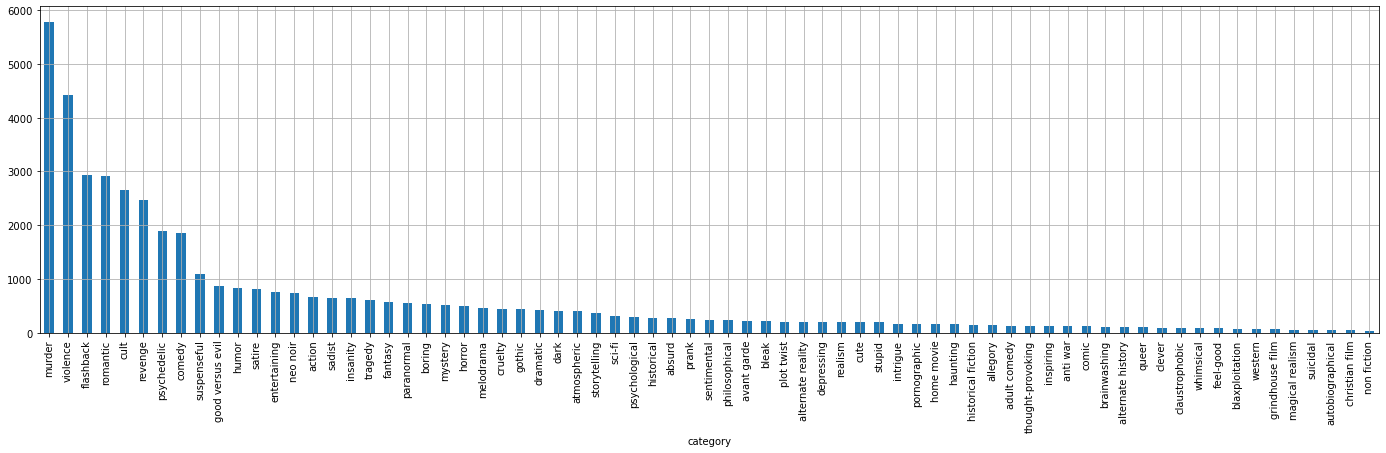

In [113]:
df_stats.sort_values('number_of_synopsis', ascending=False) \
.plot(x='category', y='number_of_synopsis', kind='bar', legend=False, grid=True, figsize=(24, 6))

In [114]:
categories = df_stats.loc[df_stats["number_of_synopsis"] > 400, "category"].tolist()
df.drop(df_stats.loc[df_stats["number_of_synopsis"] < 400, "category"].tolist(), axis=1, inplace=True)

In [115]:
df = df[df.sum(axis=1) != 0]

# Zbiór uczący i testowy

In [116]:
df_train = df[['title', 'clean_plot_synopsis', 'tags', 'split']+list(categories)].loc[(df['split'] == 'train') | (df['split'] == 'val')]
df_test = df[['title', 'clean_plot_synopsis', 'tags', 'split']+list(categories)].loc[df['split'] == 'test']

# vectorizer (słowo -> wektor)

### średnio recenzje mają długość

In [117]:
np.mean(l)

520.247100080928

In [118]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf

vectorizer = TextVectorization(max_tokens=40000, output_sequence_length=600)
text_ds = tf.data.Dataset.from_tensor_slices(df_train['clean_plot_synopsis']).batch(128)
vectorizer.adapt(text_ds)

In [119]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Ładujemy pretrenowany model

In [120]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word.lower()] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


# Tworzymy macierz z pretrenowanymi wektorami, które odpowiadają naszym słowom

In [121]:
num_tokens = len(voc)
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and embedding_vector.size > 0:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 37417 words (2583 misses)


# Definicja modelu

In [122]:
'''
https://github.com/AlexYangLi/TextClassification

ze zmienionym wyjściem na sigmoide i dodanym glove do embedding_layer 
'''

from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, Flatten, Dense, Lambda, LSTM, \
concatenate, Bidirectional, MaxPooling1D, GRU, GlobalMaxPooling1D
import keras.backend as K
import keras



class CNNRNN():
    def __init__(self, max_len, n_class, embedding_matrix):
        self.max_len = max_len
        self.n_class = n_class
        self.embedding_matrix = embedding_matrix
        self.METRICS = [keras.metrics.TruePositives(name='tp'),
                          keras.metrics.FalsePositives(name='fp'),
                          keras.metrics.TrueNegatives(name='tn'),
                          keras.metrics.FalseNegatives(name='fn'), 
                          keras.metrics.BinaryAccuracy(name='accuracy'),
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.AUC(name='auc')]

    def build(self):
        input_text = Input(shape=(self.max_len,))

        embedding_layer = Embedding(num_tokens,
                                    embedding_dim,
                                    embeddings_initializer=keras.initializers.Constant(self.embedding_matrix),
                                    trainable=False,
                                    )(input_text)
        text_embed = SpatialDropout1D(0.2)(embedding_layer)

        conv_layer = Conv1D(100, kernel_size=3, padding="valid", activation='relu')(text_embed)
        conv_max_pool = MaxPooling1D(pool_size=2)(conv_layer)

        gru_layer = Bidirectional(GRU(300, return_sequences=True))(conv_max_pool)
        sentence_embed = GlobalMaxPooling1D()(gru_layer)

        dense_layer = Dense(256, activation='relu')(sentence_embed)
        output = Dense(self.n_class, activation='sigmoid')(dense_layer)

        model = Model(input_text, output)
        model.compile(loss='binary_crossentropy', metrics=self.METRICS, optimizer="Adamax")
        
        return model

# Uczymy model

In [123]:
X_train = df_train['clean_plot_synopsis']
Y_train = df_train[categories].to_numpy()

X_test = df_test['clean_plot_synopsis']
Y_test = df_test[categories].to_numpy()

In [124]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

In [125]:
model = CNNRNN(max_len=np.shape(X_test)[1], n_class=np.shape(Y_test)[1], embedding_matrix=embedding_matrix).build()

In [126]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 100)          4000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 598, 100)          30100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 299, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 299, 600)          723600    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 600)               0   

In [72]:
filepath = 'model-full.epoch{epoch:02d}-acc{accuracy:.4f}.hdf5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=False,
                             save_weights_only=False,
                             save_freq=698)

In [30]:
history = model.fit(X_train, Y_train, epochs=10, workers=4, callbacks=checkpoint, verbose=1)

Epoch 1/10
371/371 [==============================] - 1256s 3s/step - loss: 0.1741 - tp: 506.9516 - fp: 2732.1774 - tn: 403152.3065 - fn: 17326.6398 - accuracy: 0.9432 - precision: 0.1492 - recall: 0.0384 - auc: 0.7758
Epoch 2/10
327/371 [=========================>....] - ETA: 2:21 - loss: 0.1376 - tp: 600.7187 - fp: 441.0703 - tn: 356441.4740 - fn: 15124.7370 - accuracy: 0.9581 - precision: 0.5727 - recall: 0.0359 - auc: 0.8350
Epoch 00002: saving model to model-full.epoch02-acc0.9586.hdf5
371/371 [==============================] - 1205s 3s/step - loss: 0.1375 - tp: 719.1882 - fp: 521.4946 - tn: 405346.1129 - fn: 17131.2796 - accuracy: 0.9582 - precision: 0.5746 - recall: 0.0373 - auc: 0.8349
Epoch 3/10
371/371 [==============================] - 1113s 3s/step - loss: 0.1343 - tp: 1805.0806 - fp: 1150.5780 - tn: 404757.0323 - fn: 16005.3844 - accuracy: 0.9593 - precision: 0.6079 - recall: 0.0986 - auc: 0.8414
Epoch 4/10
283/371 [=====================>........] - ETA: 4:19 - loss: 0.131

In [127]:
model = keras.models.load_model('model.epoch10-acc0.9178.hdf5')

# Ewaluacja

In [128]:
score = model.evaluate(X_test, Y_test, verbose=1)

88/88 [==============================] - 113s 1s/step - loss: 0.2452 - tp: 2307.0000 - fp: 1844.0000 - tn: 69328.0000 - fn: 5369.0000 - accuracy: 0.9085 - precision: 0.5558 - recall: 0.3005 - auc: 0.8409


In [129]:
print('accuracy: ', score[5])

accuracy:  0.9085202813148499


In [130]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )

        acc_list.append(tmp_a)
    return np.mean(acc_list)


In [131]:
def map_cat(pred, unique_cat):
    
    data = {}
    
    for c in unique_cat:
        data[c] = False
    
    df = pd.DataFrame(data, index=[0])
    unique_cat = np.array(unique_cat)
    
    df = pd.concat([df]*len(pred), ignore_index=True)
    
    for c in pred:
        tmp = (unique_cat[c])
        df[tmp] = True
        
    return df.to_numpy()

In [132]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score

In [133]:
p = model.predict(X_test, verbose=1)

88/88 [==============================] - 122s 1s/step


In [134]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for val in thresholds:
    print("For threshold: ", val)
    pred=p.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(Y_test, pred, average='micro')
    recall = recall_score(Y_test, pred, average='micro')
    f1 = f1_score(Y_test, pred, average='micro')
    accuracy = accuracy_score(Y_test, pred)
    hamming_l = hamming_loss(Y_test, pred)
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, \
accuracy-measure: {:.4f}, hamming_loss-measure: {:.4f}".format(precision, recall, f1,accuracy,hamming_l))

For threshold:  0.1
Micro-average quality numbers
Precision: 0.2307, Recall: 0.8021, F1-measure: 0.3583, accuracy-measure: 0.0028, hamming_loss-measure: 0.2797
For threshold:  0.2
Micro-average quality numbers
Precision: 0.3253, Recall: 0.6351, F1-measure: 0.4303, accuracy-measure: 0.0266, hamming_loss-measure: 0.1637
For threshold:  0.3
Micro-average quality numbers
Precision: 0.4021, Recall: 0.4990, F1-measure: 0.4453, accuracy-measure: 0.0579, hamming_loss-measure: 0.1210
For threshold:  0.4
Micro-average quality numbers
Precision: 0.4798, Recall: 0.3930, F1-measure: 0.4321, accuracy-measure: 0.0962, hamming_loss-measure: 0.1006
For threshold:  0.5
Micro-average quality numbers
Precision: 0.5558, Recall: 0.3005, F1-measure: 0.3901, accuracy-measure: 0.1108, hamming_loss-measure: 0.0915
For threshold:  0.6
Micro-average quality numbers
Precision: 0.6414, Recall: 0.2246, F1-measure: 0.3327, accuracy-measure: 0.1097, hamming_loss-measure: 0.0877
For threshold:  0.7
Micro-average qualit

In [135]:
from sklearn.metrics import classification_report

In [138]:
d = {}
for val in thresholds:
    pred=p.copy()

    pred[pred>=val]=1
    pred[pred<val]=0
    
    report = classification_report(Y_test, pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    d[val] = {'precision': df.loc['micro avg'].loc['precision'],
              'recall': df.loc['samples avg'].loc['recall'], 
              'f1-score': df.loc['micro avg'].loc['f1-score'],
              'TL': df['precision'].loc['0':'27'].loc[df['precision'] != 0].count()}

C:\Users\kacsk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kacsk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kacsk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kacsk\anaconda3\lib\site-packages\sklearn\metr

In [139]:
d

{0.1: {'precision': 0.2306856500562008,
  'recall': 0.8204348001666893,
  'f1-score': 0.35831926904498634,
  'TL': 28},
 0.2: {'precision': 0.3253470368392952,
  'recall': 0.6697380300807148,
  'f1-score': 0.43027360988526037,
  'TL': 28},
 0.3: {'precision': 0.4020997375328084,
  'recall': 0.5420421030595036,
  'f1-score': 0.44532294634032904,
  'TL': 25},
 0.4: {'precision': 0.4798027989821883,
  'recall': 0.4402597264635617,
  'f1-score': 0.43211114293898595,
  'TL': 21},
 0.5: {'precision': 0.5557696940496266,
  'recall': 0.3487662067651414,
  'f1-score': 0.3901242918745244,
  'TL': 17},
 0.6: {'precision': 0.6413690476190477,
  'recall': 0.2648509259837385,
  'f1-score': 0.3326900810497877,
  'TL': 15},
 0.7: {'precision': 0.7034777303233679,
  'recall': 0.17994616455198842,
  'f1-score': 0.24755770263016638,
  'TL': 13},
 0.8: {'precision': 0.792191435768262,
  'recall': 0.09598658325575939,
  'f1-score': 0.1485242030696576,
  'TL': 7},
 0.9: {'precision': 0.8391608391608392,
  '

In [ ]:
p_train = model.predict(X_train, verbose=1)

 87/349 [======>.......................] - ETA: 4:34

In [ ]:
d = {}
for val in thresholds:
    pred=p_train.copy()

    pred[pred>=val]=1
    pred[pred<val]=0
    
    report = classification_report(Y_train, pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    d[val] = {'precision': df.loc['micro avg'].loc['precision'],
              'recall': df.loc['samples avg'].loc['recall'], 
              'f1-score': df.loc['micro avg'].loc['f1-score'],
              'TL': df['precision'].loc['0':'27'].loc[df['precision'] != 0].count()}

In [ ]:
d